<a href="https://colab.research.google.com/github/rafael1109-moura/diagnostico-de-pacientes-com-pneumonia/blob/main/imagens_de_pneumonia%2C_melhor_resultado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-com o auxilio do gemini montei um código para verificar rapidamente se o nosso conjunto de imagens tinha um tamanho padrão, verifiquei que não, logo irei redimensionar todas as imagens para 224 x 224

-quanto a cor, por se tratar de raio x, todas as imagens são preto e branco

https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [13]:
#importações

import os
import numpy as np
import glob
import shutil
import random
import matplotlib.pyplot as plt


#importando o tensorflow mais as bibliotecas que vamos usar
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [ ]:
#para importar o dados, lembrando que está dividido em train, test, val e NORMAL, PNEUMONIA

import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [ ]:
#definição dos diretórios principais

base_dir = os.path.join(path, 'chest_xray')

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'val')

#diretorios das classes

train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

test_normal_dir = os.path.join(test_dir, 'NORMAL')
test_pneumonia_dir = os.path.join(test_dir, 'PNEUMONIA')

validation_normal_dir = os.path.join(validation_dir, 'NORMAL')
validation_pneumonia_dir = os.path.join(validation_dir, 'PNEUMONIA')

In [ ]:
TARGET_VAL_SIZE = 100
TARGET_TRAIN_SIZE = 1200

# Define the new writable base directory
new_base_dir = os.path.join('/content/', 'chest_xray_writable')

# --- 1. Copy the dataset to a writable location if it doesn't already exist ---
if not os.path.exists(new_base_dir):
    print(f"Copiando dataset de '{base_dir}' para '{new_base_dir}'...")
    shutil.copytree(base_dir, new_base_dir)
    print("Cópia concluída.")
else:
    print(f"Dataset já existe em '{new_base_dir}'. Pulando cópia.")

# Update directory paths to point to the new writable location
base_dir = new_base_dir

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'val')

# Diretorios das classes

train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

test_normal_dir = os.path.join(test_dir, 'NORMAL')
test_pneumonia_dir = os.path.join(test_dir, 'PNEUMONIA')

validation_normal_dir = os.path.join(validation_dir, 'NORMAL')
validation_pneumonia_dir = os.path.join(validation_dir, 'PNEUMONIA')


# --- 2. MODIFICAÇÃO: AUMENTAR VALIDAÇÃO (DE 8 PARA 100) ---

TARGET_VAL_SIZE = 100
INITIAL_VAL_SIZE = 8
images_to_move = TARGET_VAL_SIZE - INITIAL_VAL_SIZE # 92 imagens para cada classe

print(f"--- 1. Movendo {images_to_move} imagens de TREINO para VALIDAÇÃO (Cada Classe) ---")

def move_images(source_dir, destination_dir, count):
    """Move uma contagem aleatória de arquivos JPEG/PNG do diretório de origem para o de destino."""
    files = [f for f in os.listdir(source_dir) if f.lower().endswith(('.jpeg', '.png', '.jpg'))]
    if len(files) < count:
        print(f"AVISO: Apenas {len(files)} arquivos encontrados em {source_dir}. Movendo todos.")
        count = len(files)

    files_to_move = random.sample(files, count)

    for filename in files_to_move:
        src = os.path.join(source_dir, filename)
        dst = os.path.join(destination_dir, filename)
        shutil.move(src, dst)
    print(f"   Transferência concluída. Movidas {count} imagens de {source_dir} para {destination_dir}.")

# --- Execução da Transferência ---
move_images(train_normal_dir, validation_normal_dir, images_to_move)
move_images(train_pneumonia_dir, validation_pneumonia_dir, images_to_move)

# --- 3. MODIFICAÇÃO: REDUZIR TREINAMENTO (UNDERSAMPLING) ---

TARGET_TRAIN_SIZE = 1200

print(f"\n--- 2. Reduzindo o Conjunto de Treinamento para {TARGET_TRAIN_SIZE} (Undersampling) ---")

def undersample_images(source_dir, target_count):
    """Remove imagens aleatórias para atingir o tamanho alvo."""
    files = [f for f in os.listdir(source_dir) if f.lower().endswith(('.jpeg', '.png', '.jpg'))]
    current_count = len(files)

    if current_count <= target_count:
        print(f"   AVISO: {source_dir} já tem {current_count} imagens. Nenhuma remoção necessária.")
        return

    images_to_remove = current_count - target_count
    files_to_remove = random.sample(files, images_to_remove)

    for filename in files_to_remove:
        file_path = os.path.join(source_dir, filename)
        os.remove(file_path)

    print(f"   Remoção concluída. Removidas {images_to_remove} imagens de {source_dir}.")

# --- Execução do Undersampling ---
# A contagem atual de NORMAL deve ser 1341 - 92 = 1249
undersample_images(train_normal_dir, TARGET_TRAIN_SIZE)

# A contagem atual de PNEUMONIA deve ser 3875 - 92 = 3783
undersample_images(train_pneumonia_dir, TARGET_TRAIN_SIZE)

# --- 4. VERIFICAÇÃO FINAL ---

new_count_normal_tr = len(os.listdir(train_normal_dir))
new_count_pneumonia_tr = len(os.listdir(train_pneumonia_dir))
new_count_val_normal = len(os.listdir(validation_normal_dir))
new_count_val_pneumonia = len(os.listdir(validation_pneumonia_dir))

print("\n--- 3. Verificação Final de Contagem ---")
print(f"Treinamento NORMAL: {new_count_normal_tr} (Alvo: 1200)")
print(f"Treinamento PNEUMONIA: {new_count_pneumonia_tr} (Alvo: 1200)")
print(f"Validação NORMAL: {new_count_val_normal} (Alvo: 100)")
print(f"Validação PNEUMONIA: {new_count_val_pneumonia} (Alvo: 100)")
print(f"\nNOVO TOTAL DE TREINAMENTO: {new_count_normal_tr + new_count_pneumonia_tr}")
print(f"NOVO TOTAL DE VALIDAÇÃO: {new_count_val_normal + new_count_val_pneumonia}")

Copiando dataset de '/kaggle/input/chest-xray-pneumonia/chest_xray' para '/content/chest_xray_writable'...
Cópia concluída.
--- 1. Movendo 92 imagens de TREINO para VALIDAÇÃO (Cada Classe) ---
   Transferência concluída. Movidas 92 imagens de /content/chest_xray_writable/train/NORMAL para /content/chest_xray_writable/val/NORMAL.
   Transferência concluída. Movidas 92 imagens de /content/chest_xray_writable/train/PNEUMONIA para /content/chest_xray_writable/val/PNEUMONIA.

--- 2. Reduzindo o Conjunto de Treinamento para 1200 (Undersampling) ---
   Remoção concluída. Removidas 49 imagens de /content/chest_xray_writable/train/NORMAL.
   Remoção concluída. Removidas 2583 imagens de /content/chest_xray_writable/train/PNEUMONIA.

--- 3. Verificação Final de Contagem ---
Treinamento NORMAL: 1200 (Alvo: 1200)
Treinamento PNEUMONIA: 1200 (Alvo: 1200)
Validação NORMAL: 100 (Alvo: 100)
Validação PNEUMONIA: 100 (Alvo: 100)

NOVO TOTAL DE TREINAMENTO: 2400
NOVO TOTAL DE VALIDAÇÃO: 200


In [ ]:
#escolhendo os parametros do modelo

BATCH_SIZE = 100 #quantos exemplos vamos fornecer por vez
IMG_SHAPE = (224, 224) #lrgura e altura para os quais as imagens vão ser redimensionadas


#aqui aplicamos uma tecnica no nosso conjunto de treinamento, no intuito de aumentar o nosso conjunto e evitar o overfiting

train_data_gen = ImageDataGenerator(
      rescale=1./255, #normalização
      rotation_range=40, #rotação da imagem
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2, #zoom
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = train_data_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=IMG_SHAPE,
                                                    color_mode='grayscale',
                                                     class_mode='binary')

Found 2400 images belonging to 2 classes.


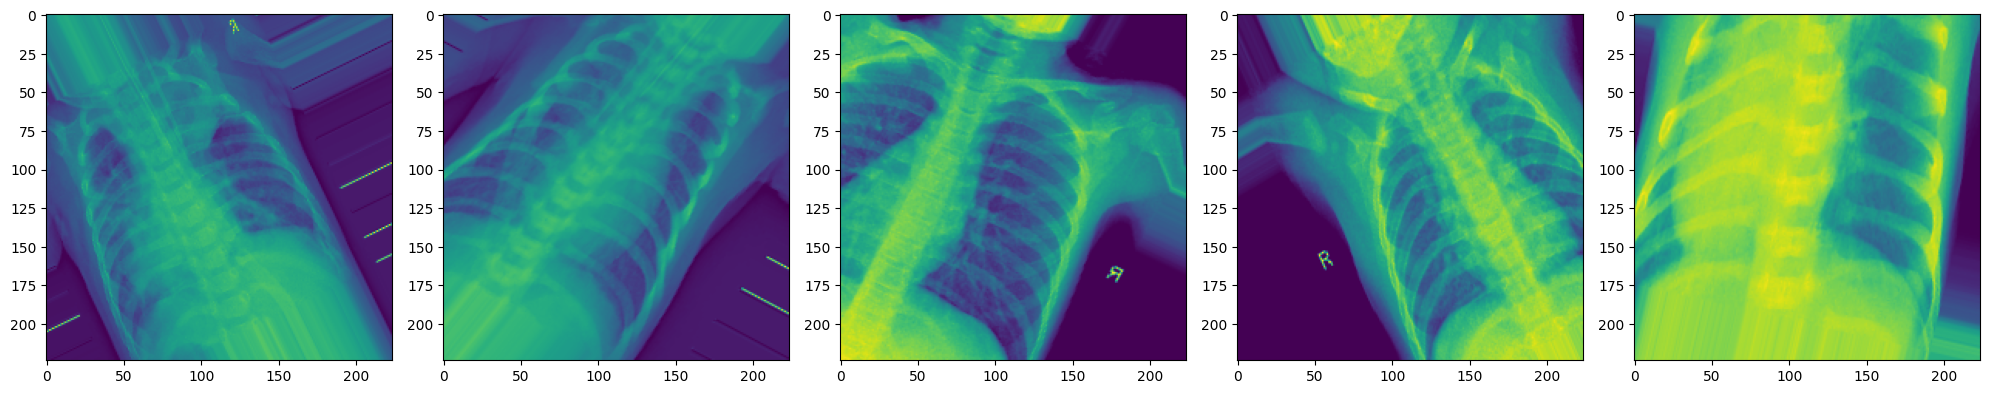

In [ ]:
#vamos plotar cinco  imagens
sample_training_images, _ = next(train_data_gen)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
plotImages(sample_training_images[:5])

In [ ]:
#aplicando uma normalização, os pizels vão ficar entre 0 e 1

validation_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
#gerando os conjuntos de validação e teste


validation_generator = validation_data_gen.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=validation_dir,
    target_size=IMG_SHAPE,
    color_mode='grayscale',
    class_mode='binary')

test_generator = test_data_gen.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=test_dir,
    target_size=IMG_SHAPE,
    color_mode='grayscale',
    class_mode='binary')

Found 200 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [19]:
#definindo o modelo

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [20]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy','precision','recall' ])

In [21]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,678,465 (36.92 MB)

 Trainable params: 9,678,465 (36.92 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
#treinamento

EPOCHS = 23

total_train = train_data_gen.samples
total_val = validation_generator.samples

history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/23
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.5059 - loss: 0.8833 - precision: 0.5044 - recall: 0.3246 - val_accuracy: 0.5400 - val_loss: 0.6932 - val_precision: 0.5952 - val_recall: 0.2500
Epoch 2/23
24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5393 - loss: 0.6927 - precision: 0.5303 - recall: 0.8125 - val_accuracy: 0.4900 - val_loss: 0.6924 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/23
24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5968 - loss: 0.6556 - precision: 0.6384 - recall: 0.3907 - val_accuracy: 0.5350 - val_loss: 0.7475 - val_precision: 0.5215 - val_recall: 0.8500
Epoch 4/23
24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7838 - loss: 0.4984 - precision: 0.8154 - recall: 0.7307 - val_accuracy: 0.5500 - val_loss: 0.7407 - val_precision: 0.5287 - val_recall: 0.9200
Epoch 5/23
24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8042 - loss: 0.4750 - precision: 0.8506 - recall: 0.7460 - val_accuracy: 0.5750 - val_loss: 0.74

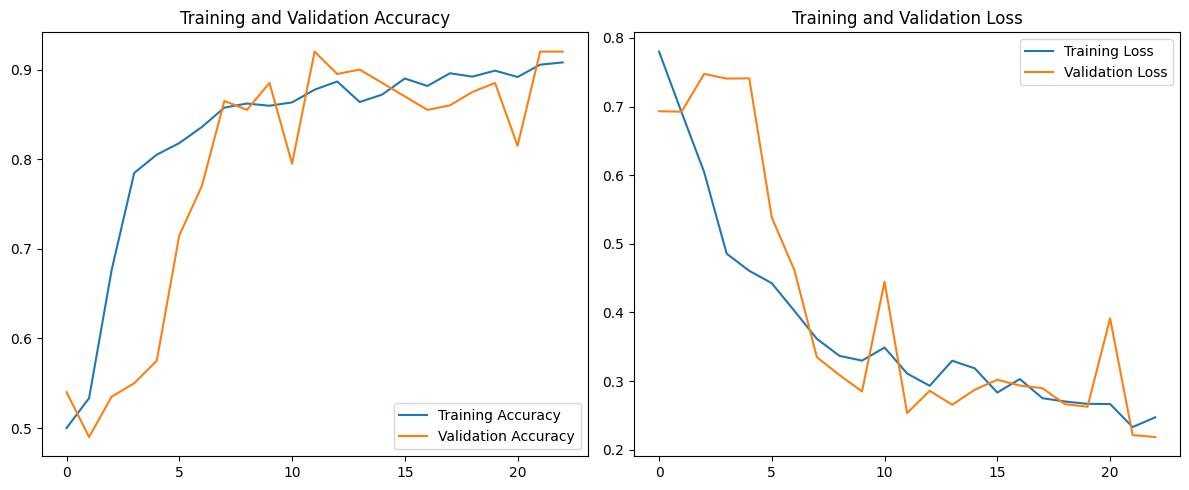

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Subplot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.savefig('accuracy_loss_plot.png')

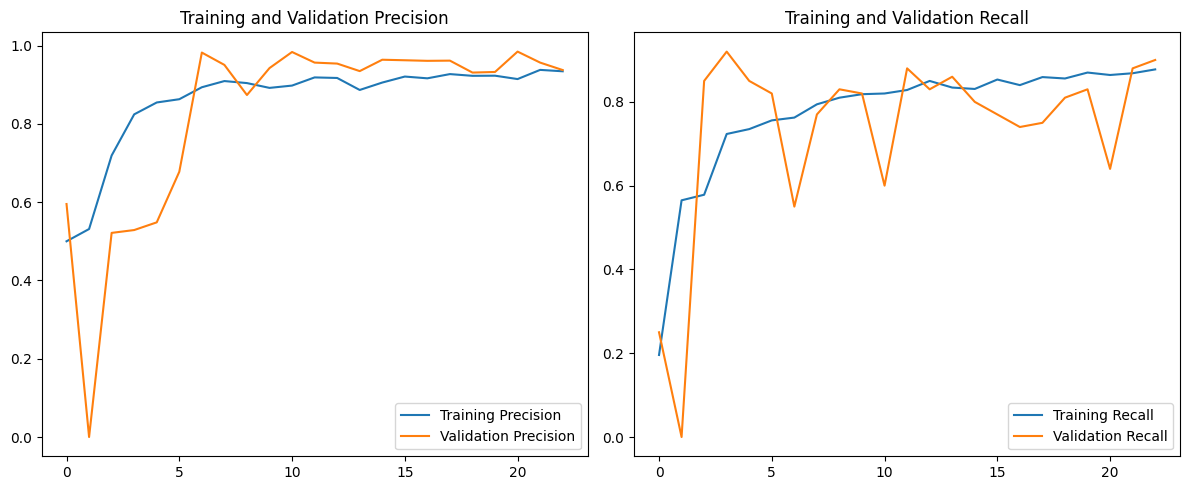

In [24]:
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))

# Subplot 1: Precision
plt.subplot(1, 2, 1)
plt.plot(epochs_range, precision, label='Training Precision')
plt.plot(epochs_range, val_precision, label='Validation Precision')
plt.legend(loc='lower right')
plt.title('Training and Validation Precision')

# Subplot 2: Recall
plt.subplot(1, 2, 2)
plt.plot(epochs_range, recall, label='Training Recall')
plt.plot(epochs_range, val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')

plt.tight_layout()
plt.savefig('precision_recall_plot.png')